In [13]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.metrics import categorical_crossentropy, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Importação das bases de treino, validação e teste

- Batch size de 32 seguindo recomendação no "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow", de que geralmente o batch size ótimo é menor do que 32.
    - Utilizo exatamente 32 devido a limitações computacionais.
- `label_mode` configurado para "categorical" por termos uma resposta binária (rural ou urbano)

In [2]:
train = (
    keras.preprocessing.image_dataset_from_directory(
        'mapas/treino',
        image_size=(224,224),
        batch_size=32,
        label_mode='categorical',
    )
)

validation = (
    keras.preprocessing.image_dataset_from_directory(
        'mapas/validacao',
        image_size=(224,224),
        batch_size=32,
        label_mode='categorical',
    )
)

test = (
    keras.preprocessing.image_dataset_from_directory(
        'mapas/teste',
        image_size=(224,224),
        batch_size=32,
        label_mode='categorical',
    )
)

Found 4000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 495 files belonging to 2 classes.


# Modelo

- Três camadas convolucionais, seguindo três camadas de pooling pelos valores máximos da "convoluted feature";

- Para as camadas convolucionais:
    - Número de filtros: múltiplos de 32
    - Tamanho do kernel determinando a extração de uma matriz 3x3 por vez.
    - Função de ativação: ReLu (HML).


- Para as camadas de pooling:
    - Resultado do pooling é uma matriz 2x2, com os valores máximos.
    - O número de strides aumenta conforme a profundidade do modelo, de 2 a 4. 
        - Strides definem o número de pixels que o kernel usa para se mover em alguma direção. Maiores valores de stride representam, portanto, imagens convolucionais menores que devem ter melhor desempenho em camadas com mais de filtros.



- Compilação do modelo:
    - Otimizador Adam com taxa de aprendizagem de 0.001.
    - Loss function é `binary_crossentropy` tendo em vista nosso output binário (rural ou urbano)

In [3]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=3),
    Conv2D(filters=96, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=4),
    Flatten(),
    Dense(units=2, activation='softmax')
])


model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 9, 96)         0

Epoch 1/10
125/125 - 173s - loss: 1.8305 - accuracy: 0.7688 - val_loss: 0.8481 - val_accuracy: 0.7980 - 173s/epoch - 1s/step
Epoch 2/10
125/125 - 144s - loss: 0.7055 - accuracy: 0.8300 - val_loss: 0.6530 - val_accuracy: 0.8100 - 144s/epoch - 1s/step
Epoch 3/10
125/125 - 149s - loss: 0.5036 - accuracy: 0.8550 - val_loss: 0.4823 - val_accuracy: 0.8560 - 149s/epoch - 1s/step
Epoch 4/10
125/125 - 151s - loss: 0.4348 - accuracy: 0.8615 - val_loss: 0.5077 - val_accuracy: 0.8200 - 151s/epoch - 1s/step
Epoch 5/10
125/125 - 169s - loss: 0.3726 - accuracy: 0.8725 - val_loss: 0.4185 - val_accuracy: 0.8620 - 169s/epoch - 1s/step
Epoch 6/10
125/125 - 177s - loss: 0.3354 - accuracy: 0.8832 - val_loss: 0.4165 - val_accuracy: 0.8500 - 177s/epoch - 1s/step
Epoch 7/10
125/125 - 183s - loss: 0.3041 - accuracy: 0.8913 - val_loss: 0.3933 - val_accuracy: 0.8560 - 183s/epoch - 1s/step
Epoch 8/10
125/125 - 177s - loss: 0.2673 - accuracy: 0.8990 - val_loss: 0.3684 - val_accuracy: 0.8660 - 177s/epoch - 1s/step


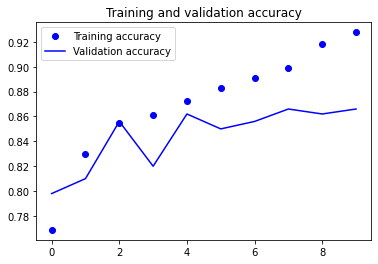

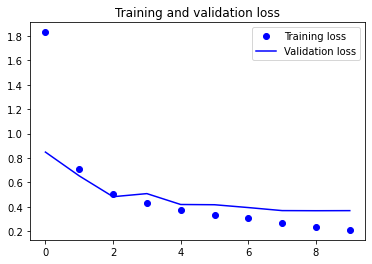

In [4]:
model_history = model.fit(
    x=train,
    validation_data=validation,
    epochs=10,
    verbose=2
)

accuracy = model_history.history['accuracy'] 
val_accuracy = model_history.history['val_accuracy'] 
loss = model_history.history['loss'] 
val_loss = model_history.history['val_loss'] 
epochs = range(len(accuracy)) 
plt.plot(epochs, accuracy, 'bo', label='Training accuracy') 
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy') 
plt.title('Training and validation accuracy') 
plt.legend() 
plt.figure() 
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend() 
plt.show()


A apresentação dos resultados de acurácia e loss indica overfitting do modelo, devido ao melhor resultado da amostra de treino sobre a de validação. A partir da época 5 (4 no gráfico, pois inicia em 0), os coeficientes do modelo rodado na base de treino seguem aumentando sua precisão, o que não é acompanhado pelos resultados do modelo rodado na amostra de validação.

O uso de data augmentation pode contornar este problema, aumentando a amostra de treino com variações das imagens já existentes nela. Mudanças de posição, rotação ou orientação das imagens podem trazer novas informações ao modelo treinado. 

# Data augmentation

In [14]:
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

In [34]:
model.fit_generator(datagen.flow(train, batch_size=32),
                              epochs = epochs, validation_data = validation,
                              verbose = 2, steps_per_epoch=treino.shape[0] // 32)

TypeError: float() argument must be a string or a real number, not 'BatchDataset'

Ainda não consegui resolver este ponto, acho que o .fit_transform espera X e Y como inputs, não sendo possível usar somente o objeto de treino com o resultado do pré processamento das imagens com `image_dataset_from_directory`.

# Aplicação na base de teste

Aplicando o método predict() ao objeto do modelo, o resultado é um array com a probabilidade calculada pelo modelo (com a função de ativação softmax) de que a imagem seja de um local de votação rural ou urbano.

De acordo com os class_names, se a maior probabilidade estiver na primeira coluna, o modelo classificou o local como rural, se estiver na segunda, como urbano.

Nota-se que em alguns casos o modelo traz probabilidades consideráveis para as duas categorias (0,31 x 0,69), por exemplo. Pode ser interessante analisar estes casos.

In [28]:
train.class_names

['rural', 'urbano']

In [29]:
model.predict(test).round(2)

16/16 [==============================] - 5s 299ms/step


array([[0.  , 1.  ],
       [0.  , 1.  ],
       [0.99, 0.01],
       [0.  , 1.  ],
       [0.92, 0.08],
       [0.05, 0.95],
       [0.01, 0.99],
       [0.97, 0.03],
       [0.94, 0.06],
       [1.  , 0.  ],
       [0.95, 0.05],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.97, 0.03],
       [0.  , 1.  ],
       [0.01, 0.99],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.31, 0.69],
       [0.  , 1.  ],
       [0.99, 0.01],
       [0.99, 0.01],
       [0.98, 0.02],
       [0.97, 0.03],
       [0.  , 1.  ],
       [0.23, 0.77],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.92, 0.08],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.01, 0.99],
       [0.32, 0.68],
       [0.  , 1.  ],
       [0.45, 0.55],
       [0.98, 0.02],
       [0.  ,

In [30]:
model.evaluate(test)

16/16 [==============================] - 5s 292ms/step - loss: 0.4007 - accuracy: 0.8545


[0.40070924162864685, 0.8545454740524292]

Avaliando o modelo na base de teste, temos o resultado  da loss function igual a 0.4, e uma accuracy de 0,85. 